# GEM continuous monitoring service: NDWI anomalies in Sahel

![anomalies](figs/anomalies.png)

## NDWI anomalies

Continuous monitoring of Earth's environment is crucial for addressing climate change, supporting sustainable socio-economic development, and informing political decisions at local, national, and international levels. It provides the foundation for evidence-based policies and actions that are essential for safeguarding our planet's future and ensuring the well-being of current and future generations. 

In GEM, we have set out to show how continuous monitoring can be done cost-effectively at scale. This section describes how one can employ GEM framework to continuously monitor Sahel region for anomalies of the normalized difference water index (NDWI).

In an approach, similar as defined for monitoring plant water stress , we have set out to monitor water content using the NDWI defined by [McFeeter](https://doi.org/10.1080/0143116960894871):
   $$ NDWI = (B03 - B08) / (B03 + B08),$$
which can be used to monitor changes related to water content in water bodies. As water bodies strongly absorb light in visible to infrared electromagnetic spectrum, NDWI uses green and near infrared bands to highlight water bodies. Index values greater than 0.5 usually correspond to water bodies. Vegetation usually corresponds to much smaller values and built-up areas to values between zero and 0.2. Additionally, we only calculate NDWI for pixels where there is data available, and the pixel is not marked as cloudy (both available in Sentinel Hub using [dataMask](https://docs.sentinel-hub.com/api/latest/user-guides/datamask/) and [cloudMask](https://docs.sentinel-hub.com/api/latest/user-guides/cloud-masks/) "bands").

To get to anomalies, historical baseline statistics are needed. In our case we calculated the per-month baselines from Sentinel-2 L1C data from January 2020 until December 2022 for each pixel of the AoI. An example is shown here:

![historical baseline](figs/NDWI_historical_baseline.png)

NDWI anomalies are defined with the following approach:

   $${NDWI}_{anomaly} = (\overline{NDWI} - NDWI)/σ_{NDWI},$$
   
where $\overline{NDWI}$ is long-term (historical) mean value of if NDWI over particular period, and $σ_{NDWI}$ is its standard deviation. The NDWI anomaly product is given in standard deviation units. It is commonly ranging from -4 to +4, negative anomalies pointing to lower than expected values (e.g. draught) and positive to higher than expected values (e.g. floods).

## GEM continuous monitoring service

The main objective of this exercise was to set-up and run the continuous monitoring and demonstrate its capabilities. In this section, we illustrate the main steps of the continuous monitoring performed with GEM framework.

We used West Sahel region as our AOI, shown here:

![AOI](figs/cmonitor_AOI.png)

We have built historical baseline statistics from Sentinel-2 L1C data spanning 3 years (2020, 2021 & 2022), and then proceeded with the workflow, outlined in the continuous monitoring example from [eo-grow-examples repository](https://github.com/sentinel-hub/eo-grow-examples/blob/main/GEM/docs/continuous_monitoring.md):   

  * for each EOPatch cell update the local catalog of Sentinel-2 (from the last run until "now", or from start in case of the first run, using [CatalogPipeline](https://github.com/sentinel-hub/eo-grow-examples/blob/main/GEM/gem_example/pipelines/catalog.py)
  * download the missing Sentinel-2 NDWI images - the newly available imagery since the last run of the pipeline using [IncrementalDownloadPipeline](https://github.com/sentinel-hub/eo-grow-examples/blob/main/GEM/gem_example/pipelines/incremental_download.py)
  * calculate anomalies as defined above with the `CalculateAnomaliesPipeline`. Additionally, as in the next steps the calculated anomalies will be ingested back to Sentinel Hub, the anomalies are reformatted to optimize storage
  * Export anomalies to TIFF files with [ExportMapsPipeline](https://github.com/sentinel-hub/eo-grow/blob/main/eogrow/pipelines/export_maps.py)
  * Ingesting resulting TIFF files to a static Sentinel Hub datacube using BYOC API with the [IngestByocTilesPipeline](https://github.com/sentinel-hub/eo-grow/blob/main/eogrow/pipelines/byoc.py)


## Accessing data

In [29]:
def plot_anomaly(data, ax, title, uint=False, rescale=False):
    if uint:
        ax.imshow(np.where(data == 0, 0.3, np.nan).squeeze(), cmap="Greys", vmin=0, vmax=1)
        if rescale:
            rescaled_data = data / 12.0 - 11
            ax.imshow(
                np.where((rescaled_data < 1) | (rescaled_data > -1), 0, np.nan).squeeze(), cmap="Greys", vmin=0, vmax=1
            )
            plot_with_cbar(
                np.where(
                    (rescaled_data > 1) | ((rescaled_data < -1) & (rescaled_data >= -10)), rescaled_data, np.nan
                ).squeeze(),
                ax,
                title,
                "RdYlGn",
                vmin=-10,
                vmax=10,
            )
        else:
            plot_with_cbar(np.where(data != 0, data, np.nan).squeeze(), ax, title, "RdYlGn", vmin=12, vmax=252)
    else:
        ax.imshow(np.where(data == -100, 0.3, np.nan).squeeze(), cmap="Greys", vmin=0, vmax=1)
        plot_with_cbar(np.where(data != -100, data, np.nan).squeeze(), ax, title, "RdYlGn", vmin=-10, vmax=10)


def plot_with_cbar(data, ax, title, cmap="viridis", **kwargs):
    divider = make_axes_locatable(ax)

    ax_cb = divider.append_axes("right", size="5%", pad=0.05)
    fig = ax.get_figure()
    fig.add_axes(ax_cb)

    im = ax.imshow(data, cmap=cmap, **kwargs)
    plt.colorbar(im, cax=ax_cb)
    ax.set_title(title)

### Per-observation data

The following eo-learn tasks will retrieve _per Sentinel-2 observation_ anomaly data. As original data was stored mapped to unsigned integers to reduce storage space, the `remap_anomalies` task will rescale the data back to [-10, 10] interval.

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

from eolearn.core import FeatureType, MapFeatureTask
from eolearn.io import SentinelHubInputTask
from sentinelhub import CRS, Band, BBox, DataCollection, MimeType, SentinelHubRequest, Unit

In [4]:
ndwi_anomaly_data_cube = DataCollection.define_byoc(
    "37d1fa19-9aaf-49a4-98f9-20daf313040f",
    bands=[Band(name="anomaly", units=(Unit.DN,), output_types=(np.float32,))],
    metabands=[Band(name="dataMask", units=(Unit.DN,), output_types=(bool,))],
)

In [24]:
# task to retrieve anomalies from Sentinel Hub
retrieve_anomalies_data = SentinelHubInputTask(
    data_collection=ndwi_anomaly_data_cube,
    bands_feature=(FeatureType.DATA, "anomaly"),
    bands=["anomaly"],
    additional_data=[(FeatureType.MASK, "dataMask")],
    resolution=120,
)

# task to re-map anomalies' values to [-10, 10]
remap_anomalies = MapFeatureTask(
    input_features=(FeatureType.DATA, "anomaly"),
    output_features=(FeatureType.DATA, "anomaly_rescaled"),
    map_function=lambda x: x / 12.0 - 11,
)

In [26]:
eop = retrieve_anomalies_data.execute(
    bbox=BBox(((399960.0, 1299960.0), (500040.0, 1400040.0)), crs=CRS("32628")),
    time_interval=["2023-02-01", "2023-02-28"],
)
eop = remap_anomalies.execute(eop)

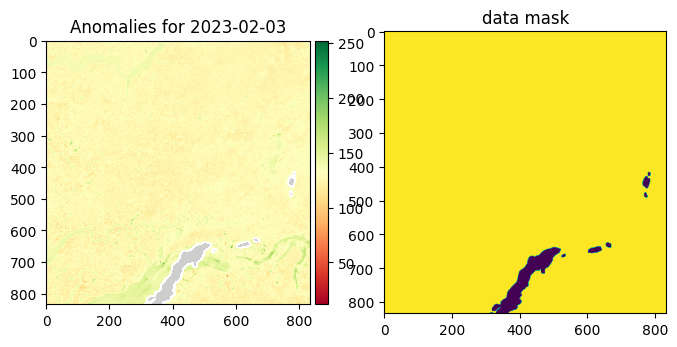

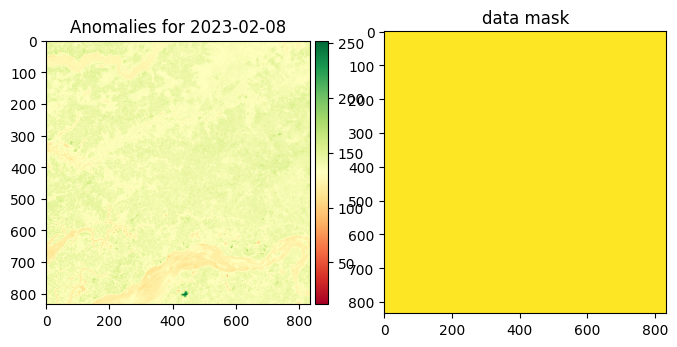

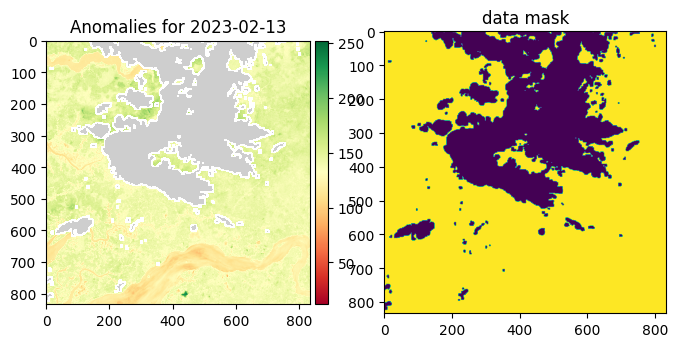

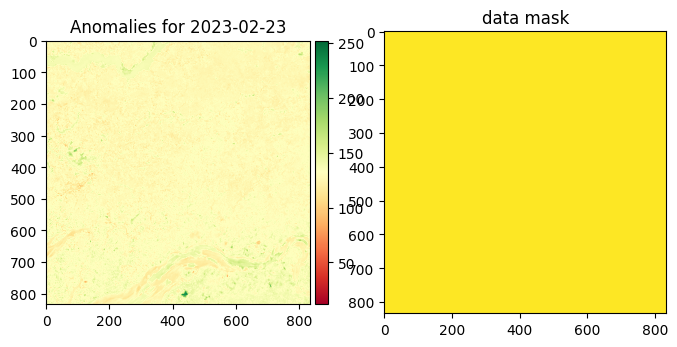

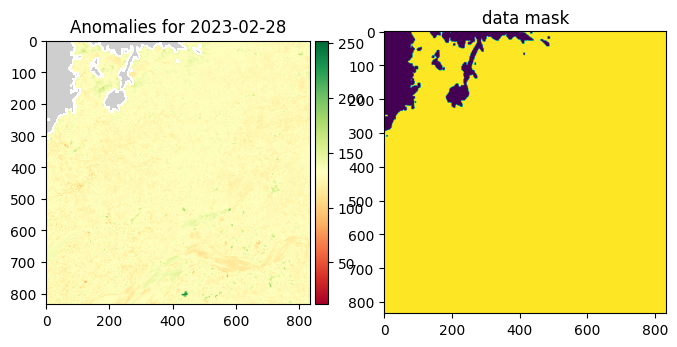

In [48]:
for idx in range(len(eop.timestamps)):
    if np.mean(eop.mask["dataMask"][idx].flatten()) > 0.4:
        fig, ax = plt.subplots(figsize=(8, 4), ncols=2)
        plot_anomaly(eop.data["anomaly"][idx], ax[0], f"Anomalies for {eop.timestamps[idx].date()}", uint=True)
        ax[1].imshow(eop.mask["dataMask"][idx].squeeze(), vmin=0, vmax=1)
        ax[1].set_title("data mask")

### Monthly composite

Monthly composite, shown in EO-Browser:
![2023-May, EO-Browser](figs/anomaly_eo-browser.png)

The same image can be requested with the following code snippet, where we off-load the mosaicking to Sentinel Hub:

In [50]:
viz_anomaly_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["anomaly", "dataMask"],
    output: { bands: 4 },
    mosaicking: Mosaicking.TILE
  };
}
//Create color ramp
  const ramps = [
    [12, 0xd7191c],
    [43.2, 0xeb6640],
    [74.4, 0xfdb165],
    [105.6, 0xfedb96],
    [136.8, 0xf8fcbd],
    [168.0, 0xcdebaf],
    [199.2, 0x9cd2a7],
    [230.4, 0x5ea7b1],
    [252, 0x0000AA]
  ];
//Create visualizer
const visualizer = new ColorRampVisualizer(ramps);
function evaluatePixel(samples) {
  let anomaly = 0;
  let mask = 0;
  samples.forEach((sample, idx) => {
    anomaly = sample.anomaly != 0 ? sample.anomaly : anomaly
    mask = sample.dataMask | mask
  });
  if (anomaly == 0){
    return [0.9,0.9,0.9,0]
  }
  let col = visualizer.process(anomaly)
  return [col[0], col[1], col[2], mask];
}
"""

In [5]:
request = SentinelHubRequest(
    evalscript=viz_anomaly_evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=ndwi_anomaly_data_cube, time_interval=["2023-05-01", "2023-05-31"]
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=BBox((-17.569541605, 4.231063941, 16.251236737, 23.712313469), CRS.WGS84),
    size=(2000, 1152),
)

In [9]:
image = request.get_data()[0]

Text(0.5, 1.0, 'Anomalies over May, 2023')

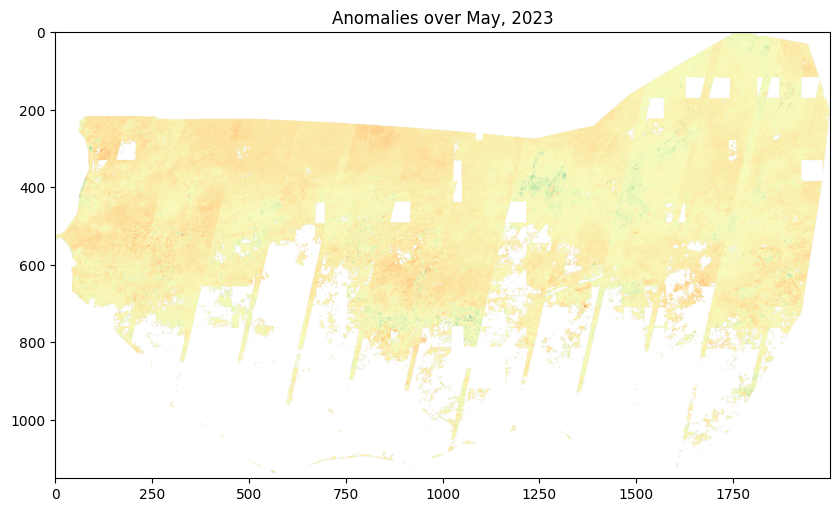

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image)
ax.set_title("Anomalies over May, 2023")